# CS6024: Course Project 
Ashvita Saishaa Ponnada BE20B007 \
Prahalaad Vijay Varahaswami BE20B024

## Importing dependencies and defining functions used for analysis

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches

In [85]:
def parse_vcf(vcf_file):
    data = []
    with open(vcf_file, 'r') as file:
        for line in file:
            if not line.startswith('#'):  # Ignore header lines
                fields = line.strip().split('\t')
                # Commented fields are blank since this is MSA to VCF
                #chrom = fields[0]
                pos = fields[1]
                #id_ = fields[2]
                ref = fields[3]
                alt = fields[4]
                #qual = fields[5]
                #filter_ = fields[6]
                #info = fields[7]
                #format_ = fields[8]
                sample_data = fields[9:]
                data.append([pos, ref, alt] + sample_data)
    columns = ['POS','REF', 'ALT'] + [f'SAMPLE_{i}' for i in range(len(sample_data))]
    df = pd.DataFrame(data, columns=columns)

    return df

In [86]:
def preprocess_vcf(vcfdf):
    # Remove instances where REF and ALT are same
    vcfdf = vcfdf[vcfdf['ALT']!=vcfdf['REF']]

    # Remove elemetns where reference allele is a gap
    vcfdf = vcfdf[~vcfdf['REF'].str.contains('[R*YKMSWBDHVN]', regex=True)]

    # Removal of unsure bases and gaps from alternate alleles
    vcfdf = vcfdf[~vcfdf['ALT'].str.contains('[R*YKMSWBDHVN]', regex=True)]
    
    # Remove the first sample (It is covered by the REF column)
    vcfdf.drop(columns='SAMPLE_0', inplace=True)

    vcfdf.reset_index(drop=True, inplace=True)

    return vcfdf 

In [87]:
def print_vcfstats(df):

    # Calculate total number of SNPs
    total_snps = len(df)

    # Calculate number of biallelic, triallelic, and tetraallelic sites
    num_biallelic = len(df[df['ALT'].apply(lambda x: ',' not in x)])
    num_tri_allelic = len(df[df['ALT'].apply(lambda x: x.count(',') == 1)])
    num_tetra_allelic = len(df[df['ALT'].apply(lambda x: x.count(',') == 2)])

    # Calculate number of transitions and transversions
    transitions = [('A', 'G'), ('G', 'A'), ('C', 'T'), ('T', 'C')]
    transversions = [('A', 'C'), ('C', 'A'), ('A', 'T'), ('T', 'A'), ('G', 'C'), ('C', 'G'), ('G', 'T'), ('T', 'G')]

    num_transitions = 0
    num_transversions = 0
    for index,row in df.iterrows():
        base1=row['REF']
        base2=row['ALT'].split(',')
        base_index=1
        for base in base2:
            #print(base1,base)
            if (base1,base) in transitions:
                num_transitions+=sum(df.iloc[index,3:]==str(base_index))
            elif (base1,base) in transversions:
                num_transversions+=sum(df.iloc[index,3:]==str(base_index))
            base_index+=1

    # Calculate ts/tv ratio
    ts_tv_ratio = num_transitions / num_transversions if num_transversions   != 0 else float('inf')

    # Print results
    print("Total number of SNPs:", total_snps)
    print("Number of biallelic sites:", num_biallelic)
    print("Number of triallelic sites:", num_tri_allelic)
    print("Number of tetraallelic sites:", num_tetra_allelic)
    print("Number of transitions:", num_transitions)
    print("Number of transversions:", num_transversions)
    print("Ts/Tv ratio:", ts_tv_ratio)

In [88]:
def hamming_distance(series1, series2):
    return sum(c1 != c2 for c1, c2 in zip(series1, series2))

In [89]:
def generate_distance_matrix(df):

    sample_genotypes = df.drop(['POS', 'REF', 'ALT'], axis=1)

    # Compute pairwise Hamming distances between samples
    distances = pd.DataFrame(index=sample_genotypes.columns, columns=sample_genotypes.columns)
    for sample1 in sample_genotypes.columns:
        for sample2 in sample_genotypes.columns:
            distances.at[sample1, sample2] = hamming_distance(sample_genotypes[sample1], sample_genotypes[sample2])
    
    return distances

In [90]:
def plot_heatmap(distances):
    # Convert the dtype of the array to int or float
    distances_numeric = distances.values.astype(int)  # or float
    
    plt.figure(figsize=(10, 8))
    plt.imshow(distances_numeric, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Distance')
    plt.title("Pairwise Hamming Distances between Samples")
    plt.xlabel("Samples")
    plt.ylabel("Samples")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [91]:
def find_locations(filename):
    # Initialize an empty list to store location information
    locations = []

    # Regular expression pattern to extract location information
    pattern = re.compile(r'A/([^/]+)/')

    # Read the FASTA file and extract location information
    with open(filename, "r") as file:
        for line in file:
            if line.startswith('>'):
                match = re.search(pattern, line)
                if match:
                    locations.append(match.group(1))
    return locations

In [92]:
def cluster_samples(distances,locations):
    
    tsne = TSNE(n_components=2)

    # Fit and transform the distance matrix using t-SNE
    embedding = tsne.fit_transform(distances)

    # Convert location labels to numerical values
    label_encoder = LabelEncoder()
    location_labels_encoded = label_encoder.fit_transform(np.array(locations))
    num_classes = len(label_encoder.classes_)

    # Define custom colors for each class
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

    # Plot the embedding colored by location labels
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=location_labels_encoded, cmap='tab10', alpha=1, s=10)

    # Add legend with custom colors
    legend_labels = label_encoder.classes_
    legend_handles = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(legend_labels)]
    plt.legend(handles=legend_handles, title='Location', loc='upper right')

    plt.title('t-SNE Embedding of Distance Matrix')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

In [93]:
def calc_allele_freq(df): # Calculates allele frequencies of each allele in the SNP
    freq_col=[]
    num_samples = len(df.columns) - 3
    for index,row in df.iterrows():
        freq=[]
        alleles=row['REF']+row['ALT'].replace(',','')
        for i in range(len(alleles)):
            freq.append((row.iloc[3:] == str(i)).sum() / num_samples)
        freq_col.append(tuple(freq))
    df['FREQ']=freq_col

In [94]:
def find_nonsyn(vcfdf,cons,gap): # Takes in vcf and consensus sequence and finds indices of non-syn mutations
    labels=[]
    mut=[]
    for _,row in vcfdf.iterrows():
        pos=int(row['POS'])-gap
        cod_pos=(pos//3)*3
        refcodon=cons[cod_pos:cod_pos+3]
        #print(refcodon)
        snpind=pos%3
        snp=row['ALT']
        altcodon=refcodon[:snpind] + snp + refcodon[snpind+1:]
        #print(altcodon)
        if DNA_codons[refcodon]!=DNA_codons[altcodon]:
            labels.append(1)
            mut.append(DNA_codons[refcodon]+'-'+DNA_codons[altcodon])
        else:
            labels.append(0)
            mut.append(None)
    return labels,mut

## Analysis of VCF files

In [95]:
###
# Initializing dataframes for all obtained VCF files
###

# Preprocess and parse VCF files for Indian HA and NA genes
ind_ha_df = preprocess_vcf(parse_vcf("MAFFT_indian_HA_vcf.txt"))
ind_na_df = preprocess_vcf(parse_vcf('MAFFT_indian_NA_vcf.txt'))

# Preprocess and parse VCF files for Global HA and NA genes
glo_ha_df = preprocess_vcf(parse_vcf('MAFFT_global_HA_vcf.txt'))
glo_na_df = preprocess_vcf(parse_vcf('MAFFT_global_NA_vcf.txt'))

# Display shape of DataFrames
print("Shape of Indian Reference HA DataFrame:", ind_ha_df.shape)
print("Shape of Indian Reference NA DataFrame:", ind_na_df.shape)
print("Shape of Global Reference HA DataFrame:", glo_ha_df.shape)
print("Shape of Global Reference NA DataFrame:", glo_na_df.shape)

Shape of Indian Reference HA DataFrame: (317, 137)
Shape of Indian Reference NA DataFrame: (288, 94)
Shape of Global Reference HA DataFrame: (837, 137)
Shape of Global Reference NA DataFrame: (698, 94)


In [96]:
for df,text in list(zip([glo_ha_df,glo_na_df,ind_ha_df,ind_na_df],['Global Reference HA','Global Reference NA','Indian Reference HA','Indian Reference NA'])):
    print(text+':')
    print_vcfstats(df)
    print('*************************')

Global Reference HA:
Total number of SNPs: 837
Number of biallelic sites: 742
Number of triallelic sites: 91
Number of tetraallelic sites: 4
Number of transitions: 42078
Number of transversions: 51570
Ts/Tv ratio: 0.8159394997091333
*************************
Global Reference NA:
Total number of SNPs: 698
Number of biallelic sites: 608
Number of triallelic sites: 86
Number of tetraallelic sites: 4
Number of transitions: 23370
Number of transversions: 29825
Ts/Tv ratio: 0.7835708298407377
*************************
Indian Reference HA:
Total number of SNPs: 317
Number of biallelic sites: 290
Number of triallelic sites: 27
Number of tetraallelic sites: 0
Number of transitions: 2252
Number of transversions: 950
Ts/Tv ratio: 2.3705263157894736
*************************
Indian Reference NA:
Total number of SNPs: 288
Number of biallelic sites: 270
Number of triallelic sites: 18
Number of tetraallelic sites: 0
Number of transitions: 1403
Number of transversions: 407
Ts/Tv ratio: 3.4471744471744

### Clustering of Indian Reference HA and NA samples based on genomic similarity

In [97]:
ind_ha_loc = find_locations('/home/pvv/csproj/h3n2_HA.fa')
ind_na_loc = find_locations('/home/pvv/csproj/h3n2_NA.fa')

In [98]:
# Generate pariwise hamming distance matrix
ind_ha_dist=generate_distance_matrix(ind_ha_df)
ind_na_dist=generate_distance_matrix(ind_na_df)

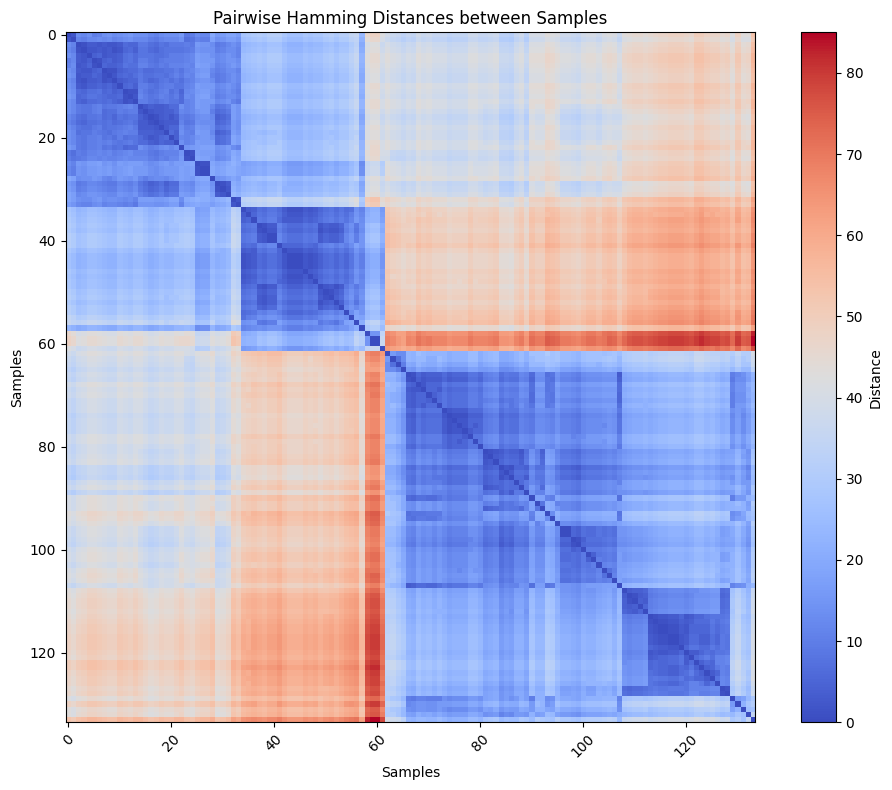

In [99]:
plot_heatmap(ind_ha_dist)

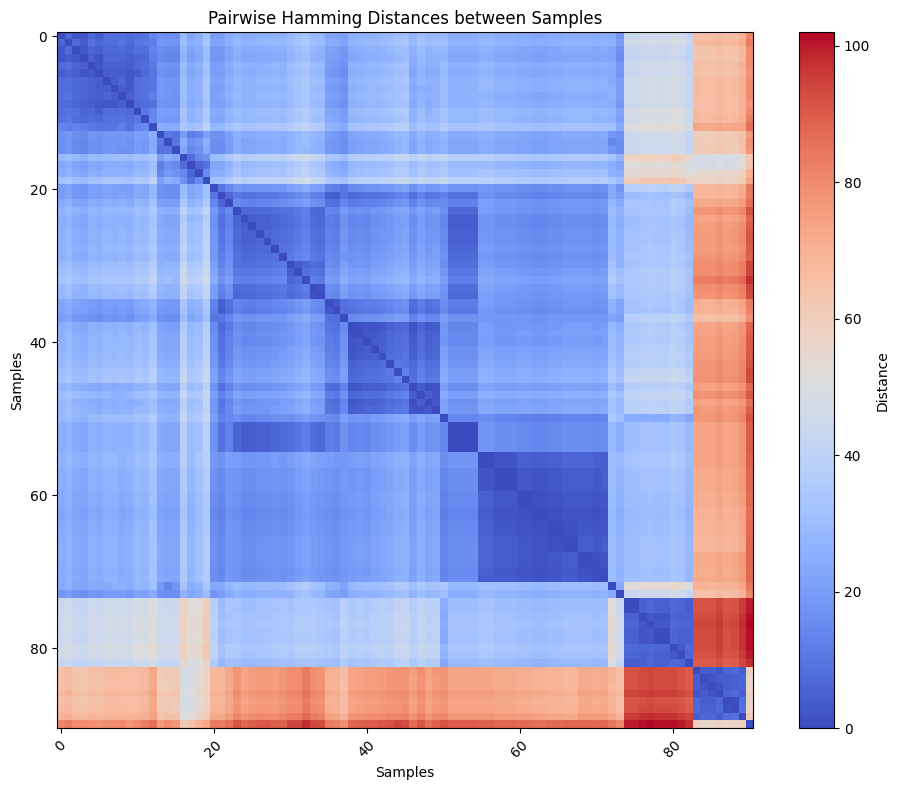

In [100]:
plot_heatmap(ind_na_dist)

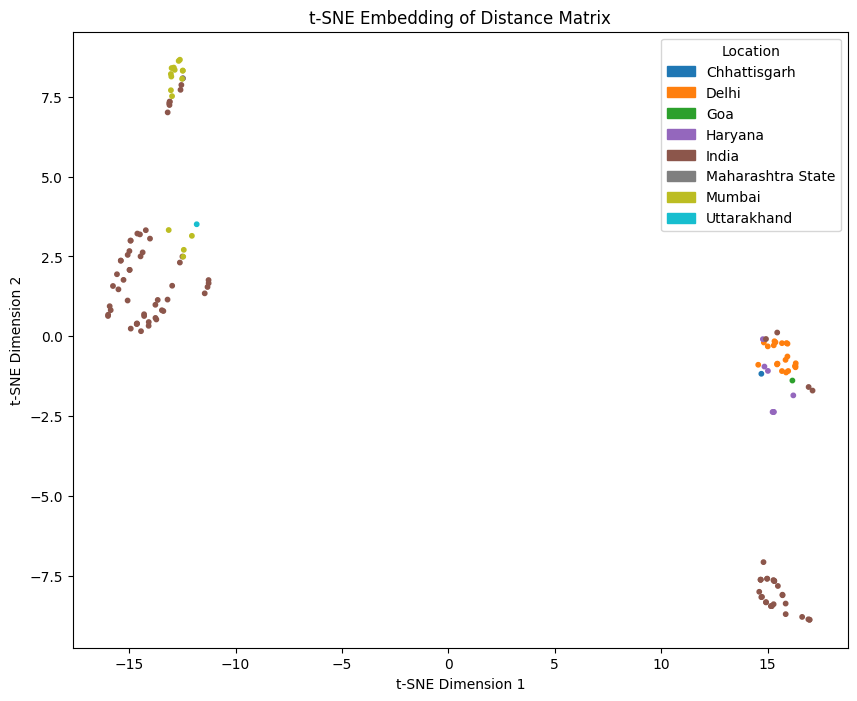

In [101]:
# Cluster samples using t-SNE  and plot 
cluster_samples(ind_ha_dist,ind_ha_loc)

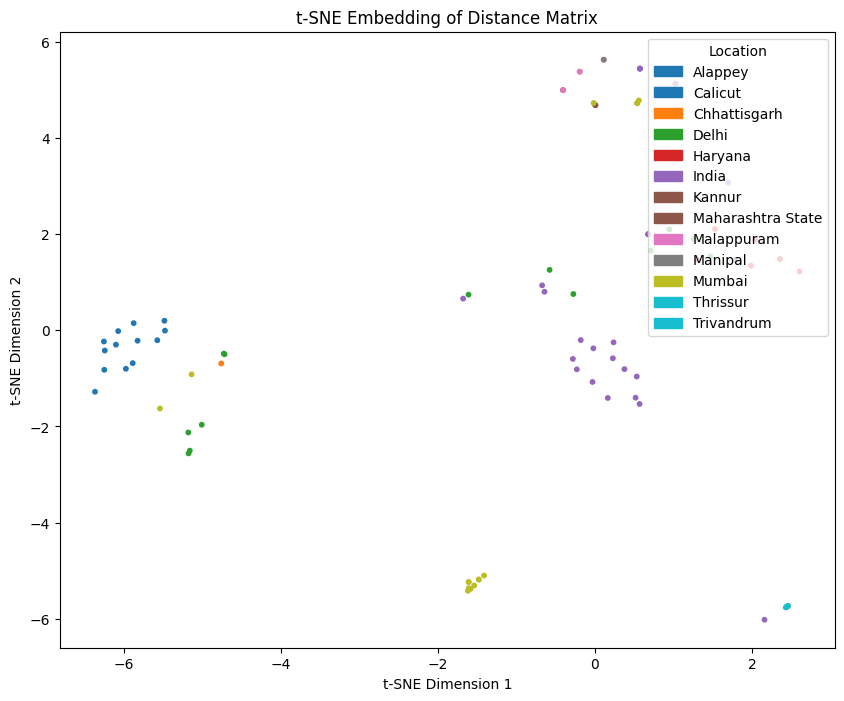

In [102]:
cluster_samples(ind_na_dist,ind_na_loc)

In [103]:
ind_ha_df.head()

,POS,REF,ALT,SAMPLE_1,SAMPLE_2,SAMPLE_3,SAMPLE_4,SAMPLE_5,SAMPLE_6,SAMPLE_7,...,SAMPLE_125,SAMPLE_126,SAMPLE_127,SAMPLE_128,SAMPLE_129,SAMPLE_130,SAMPLE_131,SAMPLE_132,SAMPLE_133,SAMPLE_134
0,35,G,A,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,0,0,0
1,37,C,A,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0,0,0,0
2,38,T,C,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,41,C,T,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,1
4,44,T,G,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
calc_allele_freq(glo_ha_df)
calc_allele_freq(glo_na_df)
calc_allele_freq(ind_ha_df)
calc_allele_freq(ind_na_df)

In [105]:
ind_ha_df.head()

,POS,REF,ALT,SAMPLE_1,SAMPLE_2,SAMPLE_3,SAMPLE_4,SAMPLE_5,SAMPLE_6,SAMPLE_7,...,SAMPLE_126,SAMPLE_127,SAMPLE_128,SAMPLE_129,SAMPLE_130,SAMPLE_131,SAMPLE_132,SAMPLE_133,SAMPLE_134,FREQ
0,35,G,A,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,"(0.9402985074626866, 0.05970149253731343)"
1,37,C,A,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,0,0,"(0.9029850746268657, 0.09701492537313433)"
2,38,T,C,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"(0.8805970149253731, 0.11940298507462686)"
3,41,C,T,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,1,"(0.9104477611940298, 0.08955223880597014)"
4,44,T,G,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"(0.9925373134328358, 0.007462686567164179)"


### Identify sub-sample specific SNPs that characterize genetic variability

For HA

In [106]:
h1 = ind_ha_df[ind_ha_df['ALT'].str.len() == 1] # select biallelic sites
h1 = h1[h1['FREQ'].apply(lambda x: x[1] >= 0.3)] # select snps with alt allele freq > 30% (to weed out random mutations)
print(h1.shape)
h1.reset_index(drop=True, inplace=True)
h1.head()

(26, 138)


,POS,REF,ALT,SAMPLE_1,SAMPLE_2,SAMPLE_3,SAMPLE_4,SAMPLE_5,SAMPLE_6,SAMPLE_7,...,SAMPLE_126,SAMPLE_127,SAMPLE_128,SAMPLE_129,SAMPLE_130,SAMPLE_131,SAMPLE_132,SAMPLE_133,SAMPLE_134,FREQ
0,84,A,C,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,"(0.5373134328358209, 0.4626865671641791)"
1,167,A,G,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,"(0.5373134328358209, 0.4626865671641791)"
2,262,A,G,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,1,0,"(0.6716417910447762, 0.3283582089552239)"
3,263,G,A,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,"(0.5373134328358209, 0.4626865671641791)"
4,293,A,G,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,"(0.5074626865671642, 0.4925373134328358)"


In [107]:
# Find occurance of alternate allele in each region label among samples
dicts_ha=[]
for i in range(len(h1)):
    d=dict()
    for j in range(len(h1.columns)-4):
        if h1.iloc[i,j+3]!='0':
            if ind_ha_loc[j] not in d.keys():
                d[ind_ha_loc[j]]=1
            else:
                d[ind_ha_loc[j]]+=1
    dicts_ha.append(d)

In [108]:
dicts_ha

[{'Chhattisgarh': 1, 'Delhi': 21, 'Goa': 1, 'Haryana': 7, 'India': 32},
 {'Chhattisgarh': 1, 'Delhi': 21, 'Goa': 1, 'Haryana': 7, 'India': 32},
 {'India': 30, 'Maharashtra State': 1, 'Mumbai': 13},
 {'Chhattisgarh': 1, 'Delhi': 21, 'Goa': 1, 'Haryana': 7, 'India': 32},
 {'India': 50, 'Maharashtra State': 1, 'Mumbai': 14, 'Uttarakhand': 1},
 {'India': 49, 'Maharashtra State': 1, 'Mumbai': 16, 'Uttarakhand': 1},
 {'Chhattisgarh': 1, 'Delhi': 21, 'Goa': 1, 'Haryana': 7, 'India': 26},
 {'Chhattisgarh': 1, 'Delhi': 21, 'Goa': 1, 'Haryana': 7, 'India': 30},
 {'India': 42, 'Mumbai': 4, 'Uttarakhand': 1},
 {'Delhi': 8, 'Haryana': 1, 'India': 33, 'Maharashtra State': 1, 'Mumbai': 13},
 {'Chhattisgarh': 1, 'Delhi': 21, 'Goa': 1, 'Haryana': 7, 'India': 32},
 {'Chhattisgarh': 1, 'Delhi': 21, 'Goa': 1, 'Haryana': 7, 'India': 32},
 {'India': 50, 'Maharashtra State': 1, 'Mumbai': 15, 'Uttarakhand': 1},
 {'Chhattisgarh': 1, 'Delhi': 21, 'Goa': 1, 'Haryana': 7, 'India': 32},
 {'Chhattisgarh': 1, 'Delhi

In [109]:
del_har_ind=[]
for idx, d in enumerate(dicts_ha):
    if d.get('Delhi') == 21 and d.get('Haryana') == 7:
        del_har_ind.append(idx)
h1=h1.iloc[del_har_ind]
len(h1)

17

For NA

In [110]:
n1 = ind_na_df[ind_na_df['ALT'].str.len() == 1]  # select biallelic sites
n1 = n1[n1['FREQ'].apply(lambda x: x[1] >= 0.3)]  # select snps with alt allele freq > 30% (to weed out random mutations)
print(n1.shape)
n1.reset_index(drop=True, inplace=True)
n1.head()

# Find occurrence of alternate allele in each region label among samples
dicts_na = []
for i in range(len(n1)):
    d = dict()
    for j in range(len(n1.columns) - 4):
        if n1.iloc[i, j + 3] != '0':
            if ind_na_loc[j] not in d.keys():
                d[ind_na_loc[j]] = 1
            else:
                d[ind_na_loc[j]] += 1
    dicts_na.append(d)

(14, 95)


In [111]:
dicts_na

[{'Alappey': 1,
  'Calicut': 12,
  'Delhi': 1,
  'Mumbai': 12,
  'Thrissur': 4,
  'Trivandrum': 1,
  'India': 1},
 {'Delhi': 5,
  'Haryana': 6,
  'India': 11,
  'Kannur': 2,
  'Maharashtra State': 1,
  'Malappuram': 4,
  'Manipal': 2,
  'Mumbai': 12},
 {'Alappey': 1,
  'Calicut': 12,
  'Chhattisgarh': 1,
  'Delhi': 7,
  'India': 2,
  'Mumbai': 4,
  'Thrissur': 4,
  'Trivandrum': 1},
 {'Haryana': 3,
  'India': 6,
  'Kannur': 2,
  'Maharashtra State': 1,
  'Malappuram': 4,
  'Manipal': 2,
  'Mumbai': 12},
 {'Chhattisgarh': 1,
  'Delhi': 9,
  'India': 16,
  'Mumbai': 4,
  'Thrissur': 4,
  'Trivandrum': 1},
 {'India': 7,
  'Kannur': 2,
  'Maharashtra State': 1,
  'Malappuram': 4,
  'Manipal': 2,
  'Mumbai': 14,
  'Thrissur': 4,
  'Trivandrum': 1},
 {'Delhi': 3,
  'India': 6,
  'Kannur': 2,
  'Maharashtra State': 1,
  'Malappuram': 4,
  'Manipal': 2,
  'Mumbai': 5,
  'Thrissur': 4,
  'Trivandrum': 1},
 {'Delhi': 7, 'Haryana': 6, 'India': 21, 'Mumbai': 9},
 {'Alappey': 1,
  'Calicut': 12,
  

In [112]:
cal_ind=[]
for idx, d in enumerate(dicts_na):
    if d.get('Calicut') == 12:
        cal_ind.append(idx)
n1=n1.iloc[cal_ind]
len(n1)

7

### Identifying Synonymous and Non-synonymous mutations

In [113]:
def read_cons(filename):
    with open(filename, 'r') as file:
        cons = file.readline()
    return cons

In [114]:
HA_cons=read_cons('HA_cons.txt')
gap_HA=29
NA_cons=read_cons('NA_cons.txt')
gap_NA=20
DNA_codons = {
    # 'M' - START, '_' - STOP
    "GCT": "A", "GCC": "A", "GCA": "A", "GCG": "A",
    "TGT": "C", "TGC": "C",
    "GAT": "D", "GAC": "D",
    "GAA": "E", "GAG": "E",
    "TTT": "F", "TTC": "F",
    "GGT": "G", "GGC": "G", "GGA": "G", "GGG": "G",
    "CAT": "H", "CAC": "H",
    "ATA": "I", "ATT": "I", "ATC": "I",
    "AAA": "K", "AAG": "K",
    "TTA": "L", "TTG": "L", "CTT": "L", "CTC": "L", "CTA": "L", "CTG": "L",
    "ATG": "M",
    "AAT": "N", "AAC": "N",
    "CCT": "P", "CCC": "P", "CCA": "P", "CCG": "P",
    "CAA": "Q", "CAG": "Q",
    "CGT": "R", "CGC": "R", "CGA": "R", "CGG": "R", "AGA": "R", "AGG": "R",
    "TCT": "S", "TCC": "S", "TCA": "S", "TCG": "S", "AGT": "S", "AGC": "S",
    "ACT": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "GTT": "V", "GTC": "V", "GTA": "V", "GTG": "V",
    "TGG": "W",
    "TAT": "Y", "TAC": "Y",
    "TAA": "_", "TAG": "_", "TGA": "_"
}

In [115]:
# Print number of nonsyn and syn mutations in ha and na ind
temp_hadf=ind_ha_df.copy()
temp_hadf=temp_hadf[temp_hadf['ALT'].str.len() == 1]
temp_hadf['Non-Syn'],temp_hadf['Mutation']=find_nonsyn(temp_hadf,HA_cons,gap_HA)
print(len(temp_hadf[temp_hadf['Non-Syn']==1]),len(temp_hadf[temp_hadf['Non-Syn']==0]))

180 110


In [116]:
temp_nadf = ind_na_df.copy()
temp_nadf = temp_nadf[temp_nadf['ALT'].str.len() == 1]
temp_nadf['Non-Syn'], temp_nadf['Mutation'] = find_nonsyn(temp_nadf, NA_cons, gap_NA)
print(len(temp_nadf[temp_nadf['Non-Syn'] == 1]), len(temp_nadf[temp_nadf['Non-Syn'] == 0]))

167 103


### List of SNPS that set apart delhi-haryana region in HA and calicut (kerala) region in NA

In [117]:
h1['Non-Syn'], h1['Mutation'] = find_nonsyn(h1, HA_cons, gap_HA)
print('Pos,Ref,Alt,Mutation')
for _, row in h1.iterrows():
    print(f"{int(row['POS']) - gap_HA},{row['REF']},{row['ALT']},{row['Mutation']}")

Pos,Ref,Alt,Mutation
55,A,C,I-T
138,A,G,N-D
234,G,A,None
323,G,A,None
411,A,C,N-H
479,G,A,S-R
524,A,T,None
531,T,C,None
538,C,T,None
561,G,T,E-_
1206,A,G,K-E
1260,A,G,R-G
1264,G,A,V-D
1437,A,C,N-H
1491,A,C,None
1499,A,G,None
1683,A,G,C-G


In [118]:
n1['Non-Syn'], n1['Mutation'] = find_nonsyn(n1, NA_cons, gap_NA)
print('Pos,Ref,Alt,Mutation')
for _, row in n1.iterrows():
    print(f"{int(row['POS']) - gap_NA},{row['REF']},{row['ALT']},{row['Mutation']}")

Pos,Ref,Alt,Mutation
85,T,C,L-S
267,A,G,P-A
1095,A,G,I-V
1100,A,G,N-K
1106,C,A,None
1281,T,A,None
1390,C,A,L-H
